## Data Preparation

Lets import our constants and global variable defined inside the constants file.

### Wiki injector
When using this classifier from the wiki injector this cell loads the global variable and constant of this notebook.
You dont need to run it when experimenting on this notebook (it will cause an error). 

In [6]:
import importlib
import sys
import os

# add the parent directory of main.py to Python path to enable import modules from the wikibase package.
notebook_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_path, '../../'))
sys.path.insert(0, parent_dir)

from wikibase_injector.classifier.constants import * 

Lets start by importing the necessary libraries and tools for text preprocessing such as `nltk`, `re`, `unidecode`, `WordNetLemmatizer`, `PorterStemmer`, and `stopwords` from `nltk.corpus`. Then we initialize the stopwords, lemmatizer, and stemmer for French language.

The `preprocess` function takes a text as input, applies various preprocessing techniques such as accent removal, removing special characters, converting the text to lowercase, tokenization, lemmatization, stemming, and removal of stop words in French. Then it returns the preprocessed text.

In [7]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import unidecode
import nltk
import re

# Function for preprocessing text data
def preprocess(text):
    # Initialization of text preprocessing tools
    stop_words = set(stopwords.words('french'))
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()

    text = unidecode.unidecode(text) # Removing accents
    text = re.sub(r'[^\w\s]', '', text) # Removing special characters
    text = text.lower() # Converting to lowercase

    tokens = nltk.word_tokenize(text) # Tokenization
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens] # Lemmatization
    stemmed_tokens = [stemmer.stem(token) for token in lemmatized_tokens] # Stemming
    cleaned_tokens = [token for token in stemmed_tokens if token not in stop_words] # Removing stop words

    text = ' '.join(cleaned_tokens) # Reassembling preprocessed text
    return text

Here, we define a function that loads and prepares the data from a JSON file. The function takes two parameters: file_path, which is the path of the JSON file to load (default value is "donnees_clusterisees.json"), and ignore_labels, which is a list of labels to be ignored. The function filters out data points with labels in the ignore_labels list, and then extracts the "name" column from the remaining data points. The function then applies the preprocess function to each name to clean the text. The function returns the cleaned names and their corresponding labels as a tuple.

In [8]:
# Load and prepare data from a JSON file
import numpy as np
import json
import os 

def prepare_data(file_path="donnees_clusterisees.json", ignore_labels=[]):
    
    if not os.path.isfile(file_path):
        file_path = os.path.abspath(os.path.join(os.path.dirname(__file__), 'donnees_clusterisees.json'))
        
    # Load the data from the JSON file
    with open(file_path, 'r') as f:
        data = json.load(f)
        
    # Filter out any data points with labels in the ignore_labels list
    data = [d for d in data if d['label'] not in ignore_labels]
    labels = [d['label'] for d in data if d['label'] not in ignore_labels]

    # Extract the name and clean the data
    names = [d['name'] for d in data]
    cleaned_names = [preprocess(name) for name in names]

    return cleaned_names, labels 

## Learning

### Train different models
---

<!-- Calculates the 95% confidence interval of the cross-validation scores. -->

Here we define a function `compute_ci_95` that calculates the 95% confidence interval of the cross-validation scores. The function takes a list of cross-validation scores as input and returns the lower and upper bounds of the confidence interval.

In [9]:
# Calculate 95% confidence interval
def compute_ci_95(cv_scores):
    std_error = np.std(cv_scores) / np.sqrt(DEFAULT_CV)
    best_score = max(cv_scores)

    # Calculate the 95% confidence interval of the cross-validation scores
    lower_bound = best_score - 1.96 * std_error
    upper_bound = best_score + 1.96 * std_error
    
    return lower_bound, upper_bound

We will define for every classifier a function to retrieve the optimal hyperparameter.

#### K-nearest neighbors
This function performs cross-validation on a range of hyperparameters to find the optimal value 
for the number of neighbors in a K-NN classifier. It returns the best hyperparameter, its associated score, 
and the 95% confidence interval of the score.

**Parameters**:
- ``neighbors_range`` (list): a list of hyperparameter values to test
- ``X_train`` (numpy array): the input features of the training set
- ``Y_train`` (numpy array): the output labels of the training set
    
**Returns**:
- ``best_k``(int): the optimal hyperparameter value
- ``best_score`` (float): the score obtained with the optimal hyperparameter
- ``lower_bound`` (float): the lower bound of the 95% confidence interval of the score
- ``upper_bound`` (float): the upper bound of the 95% confidence interval of the score

In [10]:
# Find the best hyperparameter value for a K-NN classifier using cross-validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

def get_best_hyperparam_KNNClassifier(neighbors_range, X_train, Y_train):
    # Store the cross-validation scores for each hyperparameter value
    cv_scores = []
    
    # Loop over the hyperparameter values
    for k in neighbors_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=DEFAULT_CV)
        cv_scores.append(scores.mean())

    # Compute the 95% confidence interval and find the optimal hyperparameter
    lower_bound, upper_bound = compute_ci_95(cv_scores)
    best_score = max(cv_scores)
    best_k = neighbors_range[cv_scores.index(max(cv_scores))]
    
    return best_k, best_score, lower_bound, upper_bound


#### Decision trees (max_depth)

This function performs cross-validation on a range of hyperparameters to find the optimal value for the maximum depth of a decision tree classifier. It returns the best hyperparameter, its associated score, and the 95% confidence interval of the score.

**Parameters**:
- `depth_range` (list): A list of hyperparameter values to test.
- `X_train` (numpy array): The input features of the training set.
- `Y_train` (numpy array): The output labels of the training set.

**Returns**:
- `best_depth` (int): The optimal hyperparameter value.
- `best_score` (float): The score obtained with the optimal hyperparameter.
- `lower_bound` (float): The lower bound of the 95% confidence interval of the score.
- `upper_bound` (float): The upper bound of the 95% confidence interval of the score.

In [11]:
from sklearn.tree import DecisionTreeClassifier

def get_best_hyperparam_TreeClassifier(depth_range, X_train, Y_train):
    # Store the cross-validation scores for each hyperparameter value
    cv_scores = []
    
    # Loop over the hyperparameter values
    for depth in depth_range:
        dt = DecisionTreeClassifier(max_depth=depth, random_state=42) # Create a decision tree classifier with current depth
        scores = cross_val_score(dt, X_train, Y_train, cv=DEFAULT_CV) # Perform cross-validation and store the scores
        cv_scores.append(np.mean(scores)) # Store the mean score for the current depth

    # Compute the 95% confidence interval and find the optimal hyperparameter
    lower_bound, upper_bound = compute_ci_95(cv_scores)
    best_score = max(cv_scores)
    best_depth = depth_range[np.argmax(cv_scores)]
    
    return best_depth, best_score, lower_bound, upper_bound

#### SVC Gaussian
This function performs cross-validation on a range of hyperparameters to find the optimal value for the gamma parameter in an SVM classifier with a Gaussian kernel. It returns the best hyperparameter, its associated score, and the 95% confidence interval of the score.

**Parameters**:
- ``gammas ``(list): a list of hyperparameter values to test
- ``X_train`` (numpy array): the input features of the training set
- ``Y_train`` (numpy array): the output labels of the training set
    
Returns:
- ``best_gamma ``(float): the optimal hyperparameter value
- ``best_score ``(float): the score obtained with the optimal hyperparameter
- ``lower_bound`` (float): the lower bound of the 95% confidence interval of the score
- ``upper_bound`` (float): the upper bound of the 95% confidence interval of the score

In [12]:
from sklearn.svm import SVC

def get_best_hyperparam_SVCGaussian(gammas, X_train, Y_train):
    # Store the scores
    cv_scores = []

    # Find the best hyperparameter with the highest score
    for gamma in gammas:
        svm = SVC(kernel='rbf', gamma=gamma)
        scores = cross_val_score(svm, X_train, Y_train, cv=DEFAULT_CV)
        cv_scores.append(scores.mean())
    
    # Compute the 95% confidence interval and find the optimal hyperparameter
    lower_bound, upper_bound = compute_ci_95(cv_scores)
    best_score = max(cv_scores)
    best_gamma = gammas[cv_scores.index(max(cv_scores))]
    
    return best_gamma, best_score, lower_bound, upper_bound

#### MultinomialNB

This function performs cross-validation on a range of hyperparameters to find the optimal value for the smoothing parameter in a Multinomial Naive Bayes classifier. It returns the best hyperparameter, its associated score, and the 95% confidence interval of the score.

**Parameters**:
- ``alphas ``(list): a list of hyperparameter values to test
- ``X_train`` (numpy array): the input features of the training set
- ``Y_train`` (numpy array): the output labels of the training set

**Returns**:
- ``best_alpha ``(float): the optimal hyperparameter value
- ``best_score ``(float): the score obtained with the optimal hyperparameter
- ``lower_bound`` (float): the lower bound of the 95% confidence interval of the score
- ``upper_bound`` (float): the upper bound of the 95% confidence interval of the score

In [13]:
from sklearn.naive_bayes import MultinomialNB

def get_best_hyperparam_MultinomialNB(alphas, X_train, Y_train):
    # Create an empty list to store the cross-validation scores for each hyperparameter value
    cv_scores = []
    
    # Loop over the hyperparameter values and compute the cross-validation score for each
    for alpha in alphas:
        mnb = MultinomialNB(alpha=alpha)
        scores = cross_val_score(mnb, X_train, Y_train, cv=DEFAULT_CV)
        cv_scores.append(scores.mean())

    # Compute the 95% confidence interval and find the optimal hyperparameter value
    lower_bound, upper_bound = compute_ci_95(cv_scores)
    best_score = max(cv_scores)
    best_alpha = alphas[cv_scores.index(max(cv_scores))]
    
    return best_alpha, best_score, lower_bound, upper_bound

#### SVC Polynomial

This function performs cross-validation on a range of hyperparameters to find the optimal value 
for the degree of the polynomial kernel in an SVM classifier. It returns the best hyperparameter, 
its associated score, and the 95% confidence interval of the score.

**Parameters**:
- ``degrees`` (list): a list of hyperparameter values to test
- ``X_train`` (numpy array): the input features of the training set
- ``Y_train`` (numpy array): the output labels of the training set

**Returns**:
- ``best_degree`` (int): the optimal hyperparameter value
- ``best_score ``(float): the score obtained with the optimal hyperparameter
- ``lower_bound`` (float): the lower bound of the 95% confidence interval of the score
- ``upper_bound`` (float): the upper bound of the 95% confidence interval of the score 

In [14]:
from sklearn.svm import SVC

def get_best_hyperparam_SVCPolynomial(degrees, X_train, Y_train):
    # Store the scores
    cv_scores = []

    # Find the cross-validation score for each hyperparameter value
    for degree in degrees:
        svm = SVC(kernel='poly', degree=degree)
        scores = cross_val_score(svm, X_train, Y_train, cv=DEFAULT_CV)
        cv_scores.append(scores.mean())

    # Compute the 95% confidence interval and find the optimal hyperparameter
    lower_bound, upper_bound = compute_ci_95(cv_scores)
    best_score = max(cv_scores)
    best_degree = degrees[cv_scores.index(max(cv_scores))]

    return best_degree, best_score, lower_bound, upper_bound

---
### Results analysis
We will display on a curve the scores of each of the algorithms with the best possible hyperparameter value on the test sample.

---
Let's first define a generic function to plot the scores of each algorithms with the best hyperparameter

##### `show_results_plot(results, title)`

This function is used to create a grouped bar plot to visualize the performance of different classifiers based on their scores. 

**Parameters:**

- `results`: A list of dictionaries containing the performance metrics for each classifier.
- `title`: A string specifying the title of the plot.

**Returns:**

This function does not return anything, it simply displays the plot.

The plot shows the following metrics for each classifier:

- Best Score
- Accuracy
- F1 Score
- Precision

Each metric is represented by a different color in the plot. The x-axis shows the name of each classifier and the y-axis shows the score range from 0 to 1. The legend shows which color represents which metric.


In [15]:
import matplotlib.pyplot as plt

def show_results_plot(results, title):
    # Get the data
    classifiers = [r['Classifier'] for r in results]
    best_scores = [r['Best Score'] for r in results]
    accuracies = [r['Accuracy'] for r in results]
    f1_scores = [r['F1 Score'] for r in results]
    precisions = [r['Precision'] for r in results]

    # Set the width of the bars
    bar_width = 0.2

    # Set the positions of the bars on the x-axis
    r1 = np.arange(len(classifiers))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]

    # Set the colors and edgecolors of the bars
    best_score_color = "#1f77b4"
    accuracy_color = '#ff7f0e'
    f1_score_color = '#2ca02c'
    precision_color = '#d62728'

    edgecolors = 'black'

    # Plot the bar charts
    plt.bar(r1, best_scores, color=best_score_color, edgecolor=edgecolors, width=bar_width, label='Best Score')
    plt.bar(r2, accuracies, color=accuracy_color, edgecolor=edgecolors, width=bar_width, label='Accuracy')
    plt.bar(r3, f1_scores, color=f1_score_color, edgecolor=edgecolors, width=bar_width, label='F1 Score')
    plt.bar(r4, precisions, color=precision_color, edgecolor=edgecolors, width=bar_width, label='Precision')

    # Add xticks on the middle of the group bars
    plt.xlabel('Classifier', fontweight='bold')
    plt.xticks([r + bar_width*1.5 for r in range(len(classifiers))], classifiers, rotation=45, ha='right')
    plt.ylabel('Score', fontweight='bold')

    # Add a title
    plt.title(title, fontweight='bold')
    plt.legend()

    # Set the figure size
    plt.gcf().set_size_inches(15, 8)

    # Set the y-axis range
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Show the plot
    plt.show()

We also define a function to evaluate the classification models on test data using four metrics: accuracy, precision, recall, and F1 score.
    
**Parameters**:

- `model`: the classification model to evaluate
- `X_test`: the feature values of the test data
- `Y_test`: the target values of the test data
    
**Returns**:
- ``accuracy``: the accuracy of the model on the test data
- ``precision``: the precision of the model on the test data
- ``recall``: the recall of the model on the test data
- ``f1``: the F1 score of the model on the test data
- ``Y_pred``: the predicted target values of the test data

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_classification_model(model, X_test, Y_test):
    # Predict on test data
    Y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics on test data
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='weighted')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

    # Return evaluation metrics and confidence interval
    return accuracy, precision, recall, f1, Y_pred

The following code defines functions that implement different classification algorithms to predict the target variable of a dataset. The functions take as input training and testing sets, and output a dictionary containing various performance metrics of the classifier, such as accuracy, precision, recall, F1-score, and the predicted values for the test set.

The classification algorithms implemented are:
- K-nearest neighbors
- Decision tree
- Multinomial Naive Bayes
- Gaussian Support Vector Machine
- Polynomial Support Vector Machine

For each algorithm, a range of values is defined for the hyperparameter that controls the behavior of the algorithm. 

The function `get_best_hyperparam_*` finds the best value of the hyperparameter by using cross-validation on the training set. <br>
The function `evaluate_classification_model` evaluates the performance of the classifier on the test set.

The output dictionary of each function contains not only the performance metrics and the predicted values, but also the name of the classifier, the name of the hyperparameter, and the best value found for the hyperparameter during training. This makes it easy to compare the performance of different classifiers with respect to different hyperparameters.


In [17]:
def predict_with_KNN(X_train, X_test, Y_train, Y_test):
    neighbors_range = range(1, 20)
    best_k, best_score, lower_bound, upper_bound = get_best_hyperparam_KNNClassifier(neighbors_range, X_train, Y_train)

    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X_train, Y_train)

    # evaluate the model
    accuracy, precision, recall, f1, Y_pred = evaluate_classification_model(knn, X_test, Y_test)
    return {
        CLASSIFIER: 'K-nearest neighbors',
        HYPERPARAMETER: 'Number of neighbors',
        BEST_HYPERPARAMETER: best_k,
        BEST_SCORE: best_score,
        LOWER_BOUND: lower_bound,
        UPPER_BOUND: upper_bound,
        F1_SCORE: f1,
        ACCURACY: accuracy,
        PRECISION: precision,
        RECALL: recall,
        PREDICTION: Y_pred
    }

def predict_with_DECISIONTREE(X_train, X_test, Y_train, Y_test):
    depth_range = range(1, 21)
    best_depth, best_score, lower_bound, upper_bound = get_best_hyperparam_TreeClassifier(depth_range, X_train, Y_train)

    # Train classifier
    dect = DecisionTreeClassifier(max_depth=best_depth)
    dect.fit(X_train, Y_train)

    # evaluate the model
    accuracy, precision, recall, f1, Y_pred = evaluate_classification_model(dect, X_test, Y_test)
    return {
        CLASSIFIER: 'Decision tree',
        HYPERPARAMETER: 'Maximum tree depth',
        BEST_HYPERPARAMETER: best_depth,
        BEST_SCORE: best_score,
        LOWER_BOUND: lower_bound,
        UPPER_BOUND: upper_bound,    
        F1_SCORE: f1,
        ACCURACY: accuracy,
        PRECISION: precision,
        RECALL: recall,
        PREDICTION: Y_pred
    }

def predict_with_MultinomialNB(X_train, X_test, Y_train, Y_test):
    # Define the range of values for the hyperparameter to tune
    alphas = range(1, 25)
    best_alpha, best_score, lower_bound, upper_bound = get_best_hyperparam_MultinomialNB(alphas, X_train, Y_train)

    # Train classifier
    perc = MultinomialNB(alpha=best_alpha)
    perc.fit(X_train, Y_train)

    # evaluate the model
    accuracy, precision, recall, f1, Y_pred = evaluate_classification_model(perc, X_test, Y_test)
    return {
        CLASSIFIER: 'Multinomial NB',
        HYPERPARAMETER: 'Alpha',
        BEST_HYPERPARAMETER: best_alpha,
        BEST_SCORE: best_score,
        LOWER_BOUND: lower_bound,
        UPPER_BOUND: upper_bound,
        F1_SCORE: f1,
        ACCURACY: accuracy,
        PRECISION: precision,
        RECALL: recall,
        PREDICTION: Y_pred
    }

def predict_with_SVCGAUSSIAN(X_train, X_test, Y_train, Y_test):
    # Define the range of values for the hyperparameter to tune
    gammas = np.arange(0.01, 1, 0.1)
    best_gamma, best_score, lower_bound, upper_bound = get_best_hyperparam_SVCGaussian(gammas, X_train, Y_train)

    # Train classifier
    svc_gaussian = SVC(kernel='rbf', gamma=best_gamma)
    svc_gaussian.fit(X_train, Y_train)

    # evaluate the model
    accuracy, precision, recall, f1, Y_pred = evaluate_classification_model(svc_gaussian, X_test, Y_test)
    return {
        CLASSIFIER: 'Gaussian SVM',
        HYPERPARAMETER: 'Gamma',
        BEST_HYPERPARAMETER: best_gamma,
        BEST_SCORE: best_score,
        LOWER_BOUND: lower_bound,
        UPPER_BOUND: upper_bound,
        F1_SCORE: f1,
        ACCURACY: accuracy,
        PRECISION: precision,
        RECALL: recall,
        PREDICTION: Y_pred
    }

def predict_with_SVCPOLYNOMIAL(X_train, X_test, Y_train, Y_test):
    # Define the range of values for the hyperparameter to tune
    degrees = range(1, 6)
    best_degree, best_score, lower_bound, upper_bound = get_best_hyperparam_SVCPolynomial(degrees, X_train, Y_train)

    # Train classifier
    svc_gaussian = SVC(kernel='poly', degree=best_degree)
    svc_gaussian.fit(X_train, Y_train)

    # evaluate the model
    accuracy, precision, recall, f1, Y_pred = evaluate_classification_model(svc_gaussian, X_test, Y_test)
    return {
        CLASSIFIER: 'Polynomial SVM',
        HYPERPARAMETER: 'Degree',
        BEST_HYPERPARAMETER: best_degree,
        BEST_SCORE: best_score,
        LOWER_BOUND: lower_bound,
        UPPER_BOUND: upper_bound,
        F1_SCORE: f1,
        ACCURACY: accuracy,
        PRECISION: precision,
        RECALL: recall,
        PREDICTION: Y_pred
    }

---
### Prediction results (on test set)
---
Lets write a general function to display the results in a dataframe

In [18]:
import pandas as pd

def result_into_df(results):  
    df = pd.DataFrame(results)
    # Sort the dataframe by the column named BEST_SCORE in descending order
    df_sorted = df.sort_values(by=BEST_SCORE, ascending=False)
    
    # Return the sorted dataframe
    return df_sorted

We also define a general function to plot the classifed data.

`show_monuments_by_label(Y_pred, X_test)`


This function creates a scatter plot to display the predicted labels for each monument in the test set. The `Y_pred` parameter is a list of predicted labels for each monument in the `X_test` parameter. The `X_test` parameter is a sparse matrix containing the test data. 

The function first creates a list of monument names from the sparse matrix using the `vectorizer.inverse_transform` method. It then creates a Pandas DataFrame with the monument names, predicted labels, and their index in the test set. 

Next, the function creates a dictionary to map each label to a color using the `LABELS_NAMES` global variable. The function creates a scatter plot trace for each label in the dictionary. The `mask` variable is used to filter the DataFrame by the label ID, and the trace is created using the filtered data.

The function uses Plotly to create the plot, with each trace represented by a different color.

In [19]:
import plotly.graph_objects as go
import plotly.express as px

def show_monuments_by_label(Y_pred, X_test):
    # Create a list of monument names
    monuments = vectorizer.inverse_transform(X_test)
    names = [', '.join(m) for m in monuments]

    # Create a data frame with the monument names, their predicted labels, and their index in the test set
    df = pd.DataFrame({'Monument': names, 'Label': Y_pred, 'Index': list(range(X_test.shape[0]))})

    # Create a dictionary to map labels to colors
    label_to_color = {label_name: px.colors.qualitative.Dark24[i] for i, label_name in enumerate(LABELS_NAMES.values())}

    # Create a trace for each label
    traces = []
    for label_id, label_name in LABELS_NAMES.items():
        mask = df['Label'] == label_id
        traces.append(go.Scatter(x=df.loc[mask, 'Index'], y=[label_name] * mask.sum(),
                                 mode='markers',
                                 text=df.loc[mask, 'Monument'],
                                 hovertemplate='%{text}',
                                 marker=dict(size=10, color=label_to_color[label_name]),
                                 name='Label {}'.format(label_name)))

    # Set the plot title and axis labels
    layout = go.Layout(title='Monument Labels',
                       xaxis_title='Monument Index',
                       yaxis_title='Predicted Label')

    # Create the figure and show the plot
    fig = go.Figure(data=traces, layout=layout)
    fig.show()

The `split_data_training_test` function splits the input data and labels into training and testing sets. It uses the `train_test_split` function from the `sklearn.model_selection` module to split the data into training and testing sets. The `test_size` parameter determines the proportion of data that is used for testing.

After the data is split, the function fits and transforms the CountVectorizer object on the training data using the `fit_transform` method. The transformed training data is then returned along with the transformed testing data, as well as the corresponding training and testing labels.

This function is useful for preparing data for our models.

In [20]:
from sklearn.model_selection import train_test_split

def split_data_training_test(X, labels, test_size=0.3):
    X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size=test_size, random_state=42)
    
    # Fit and transform the CountVectorizer on your training data
    X_train = vectorizer.fit_transform(X_train)

    # Transform the test data using CountVectorizer object
    X_test = vectorizer.transform(X_test)
    return X_train, X_test, Y_train, Y_test

`predict_monuments_class_with_allClassifier()`

This function predicts the class labels for the monuments dataset using multiple classifiers. It first prepares the data by calling the `prepare_data()` function, and then splits the data into training and testing sets using `split_data_training_test()`. It then calls the following functions to predict the class labels:
- `predict_with_KNN()`
- `predict_with_DECISIONTREE()`
- `predict_with_MultinomialNB()`
- `predict_with_SVCGAUSSIAN()`
- `predict_with_SVCPOLYNOMIAL()`

The results from each classifier are stored in a list and returned along with the testing data.


In [21]:
def predict_monuments_class_with_allClassifier():
    data, labels = prepare_data(ignore_labels=[13])
    X_train, X_test, Y_train, Y_test = split_data_training_test(data, labels)
    
    results = []
    results.append(predict_with_KNN(X_train, X_test, Y_train, Y_test)) 
    results.append(predict_with_DECISIONTREE(X_train, X_test, Y_train, Y_test))
    results.append(predict_with_MultinomialNB(X_train, X_test, Y_train, Y_test))
    results.append(predict_with_SVCGAUSSIAN(X_train, X_test, Y_train, Y_test))
    results.append(predict_with_SVCPOLYNOMIAL(X_train, X_test, Y_train, Y_test))
    
    return results, X_test

Using the `predict_monuments_class_with_allClassifier()` function to obtain predictions for the test data ny using several classifiers, we then creates a DataFrame with the results using the `result_into_df()` function. 

The resulting DataFrame `df` contains the predictions of each classifier for each sample in the test set, as well as the best score achieved by each classifier. This DataFrame can be used to compare the performance of different classifiers on the task of predicting monument labels.

In [22]:
results, X_test = predict_monuments_class_with_allClassifier()
df = result_into_df(results)
df

,Classifier,Hyperparameter,Best Hyperparameter,Best Score,Lower Bound,Upper Bound,F1 Score,Accuracy,Precision,Recall,Prediction
1,Decision tree,Maximum tree depth,11.00,0.999598,0.921327,1.077870,0.999062,0.999062,0.999065,0.999062,"[1, 12, 1, 0, 7, 0, 10, 1, 2, 4, 2, 0, 1, 1, 0..."
3,Gaussian SVM,Gamma,0.11,0.997990,0.983652,1.012329,0.999062,0.999062,0.999065,0.999062,"[1, 12, 1, 0, 7, 0, 10, 1, 2, 4, 2, 0, 1, 1, 0..."
4,Polynomial SVM,Degree,1.00,0.997990,0.990290,1.005691,0.998135,0.998124,0.998176,0.998124,"[1, 12, 1, 0, 7, 0, 10, 1, 2, 4, 2, 0, 1, 1, 0..."
0,K-nearest neighbors,Number of neighbors,4.00,0.993161,0.992583,0.993740,0.995281,0.995310,0.995397,0.995310,"[1, 12, 1, 0, 7, 0, 10, 1, 2, 4, 2, 0, 1, 1, 0..."
2,Multinomial NB,Alpha,1.00,0.989140,0.971774,1.006507,0.995123,0.995310,0.995346,0.995310,"[1, 12, 1, 0, 7, 0, 10, 1, 2, 4, 2, 0, 1, 1, 0..."


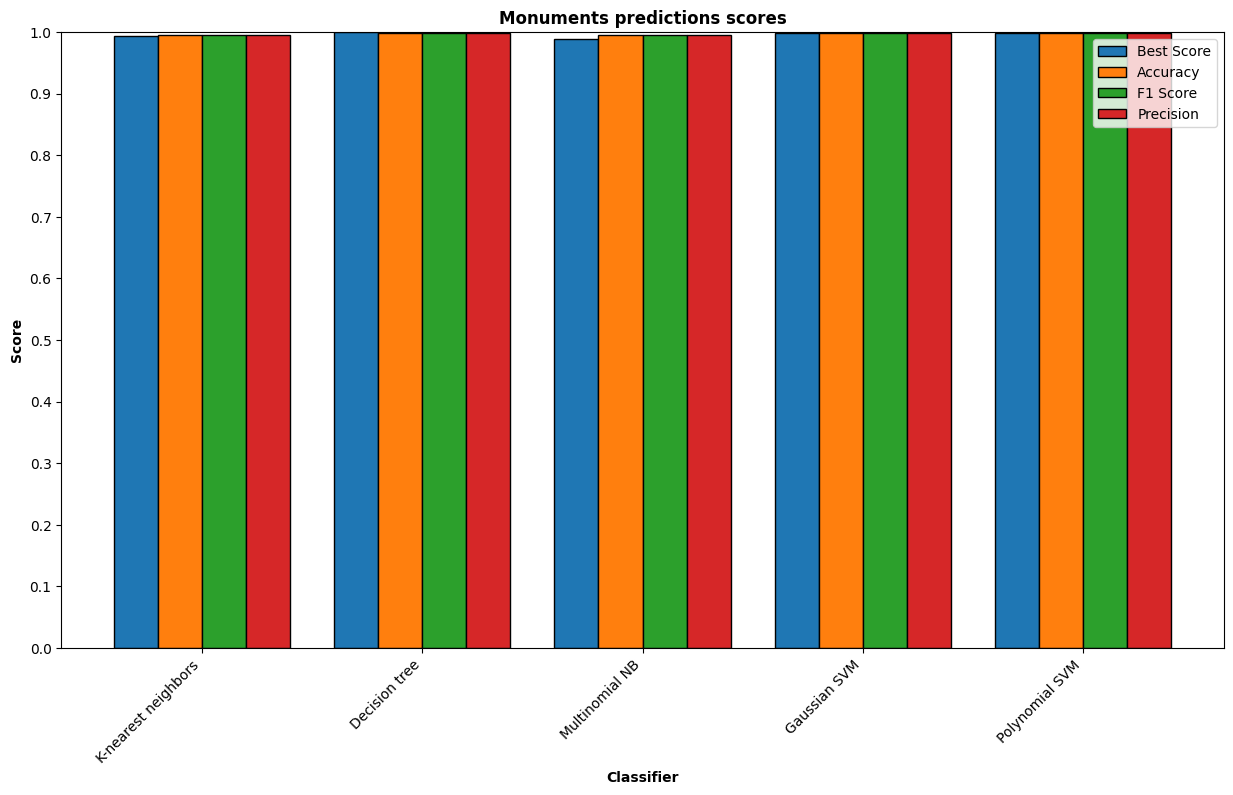

In [23]:
show_results_plot(results, "Monuments predictions scores")

This code segment tests the Gaussian SVM classifier on the monuments dataset. 

It selects the row corresponding to the Gaussian SVM classifier from the results dataframe generated by the `result_into_df()` function. Then, it extracts the predicted labels from this row and passes them along with the test set to the `show_monuments_by_label()` function to visualize the predictions. 

The visualization plots the predicted labels for each monument in the test set as points on a 2D scatterplot, where each label is assigned a distinct color. 

In [24]:
# get the row corresponding to the Gaussian SVM classifier
svm_row = df.loc[df[CLASSIFIER] == 'Gaussian SVM']

# get the prediction values for the Gaussian SVM classifier
svm_predictions = svm_row[PREDICTION].values[0]

show_monuments_by_label(svm_predictions, X_test)

---
### Prediction results (on new data)
---

Predicts the labels of new data using a decision tree classifier.

**Parameter**:
- ``data_test``: a list of dictionaries containing the name and description of new monuments

**Returns**:
- ``new_data_label``: a numpy array containing the predicted labels for the new data
- ``X_test``: a sparse matrix containing the transformed names and descriptions of the new data


In [25]:
def predict_labels_decisiontree(data_test):   
    
    data, labels = prepare_data(ignore_labels=[13])
    X_train, X_test, Y_train, Y_test = split_data_training_test(data, labels)
    classifier_result = predict_with_DECISIONTREE(X_train, X_test, Y_train, Y_test)
    hyper_param = classifier_result[BEST_HYPERPARAMETER]
    
    train_data, Y_train = prepare_data()

    # Fit and transform the CountVectorizer on your training data
    X_train = vectorizer.fit_transform(train_data)

    # Train classifier
    decision_tree = DecisionTreeClassifier(max_depth=hyper_param)
    decision_tree.fit(X_train, Y_train)

    # Extraction de la colonne "name" 
    names = [d['name'] for d in data_test]
    # Application de la fonction preprocess sur les noms et descriptions de monuments
    clean_names = [preprocess(name) for name in names]

    # Transform the test data using CountVectorizer object
    X_test = vectorizer.transform(clean_names)
    new_data_label = decision_tree.predict(X_test)
            
    return new_data_label, X_test

---
This cell is used for testing purposes within this notebook using an external dataset. It imports modules from the `wikibase_injector` package to retrieve data from CSV and an API, predicts the labels of the retrieved data using the `predict_labels_decisiontree` function, and displays the resulting labels using the `show_monuments_by_label` function.

In [26]:
import os
import sys

# add the parent directory of main.py to Python path to enable import modules from the wikibase package.
notebook_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_path, '../../'))
sys.path.insert(0, parent_dir)

import wikibase_injector.data_formatter.data_clic_csv as data_clic_csv
import wikibase_injector.data_formatter.data_loire_web as data_loire_web
import wikibase_injector.data_formatter.data_culture_api as data_culture_api

_, data_test = data_clic_csv.retrieve_data("../../../data/monuments_historiques_departement42_2023-02-11.csv")
_, data_api = data_loire_web.retrieve_data()
data_test.extend(data_api)

data_labels, X_test = predict_labels_decisiontree(data_api)
show_monuments_by_label(data_labels, X_test)

Current Path: c:\Users\Administrateur\Documents\GitHub\WikiStone\wikibase\wikibase_injector\classifier


---

This function will be used in our application (data_injector) to predict the monuments category and return data labelised.

**Parameter**: <br>
- ``data_test`` (list): A list of dictionaries, where each dictionary represents a monument with the following keys:
    - '_name_' : a string representing the name of the monument
    - '_address_' : a string representing the address of the monument
    - '_description_' : a string representing the description of the monument
    - ect...

**Returns**:<br>
- ``data_test`` (list): A list of dictionaries, where each dictionary represents a monument with the following keys:
    - '_name_' : a string representing the name of the monument
    - '_address_' : a string representing the address of the monument
    - '_description_' : a string representing the description of the monument
    - '_category_' : a string representing the predicted category of the monument
    - ect...

refer to  `data_formater` module to see the structure of the ``data_test``

In [27]:
def predict_monuments_category(data_test):

    data_labels, X_test = predict_labels_decisiontree(data_test)
    show_monuments_by_label(data_labels, X_test)
    
    monuments = vectorizer.inverse_transform(X_test)
    names = [', '.join(m) for m in monuments]

    # Create a data frame with the monument names, their predicted labels, and their index in the test set
    df = pd.DataFrame({'Monument': names, 'Label': data_labels, 'Index': list(range(X_test.shape[0]))})
    
    # Create a dictionary to map each index in the test set to its predicted label
    index_to_label = dict(zip(df['Index'], df['Label']))

    # Add the predicted labels to data_test
    for i, monument in enumerate(data_test):
        monument_label = index_to_label[i]
        monument['category'] = LABELS_NAMES[monument_label]
    
    return data_test